# Linear models for classification

In this lab we work with the [Fashion-MNIST dataset](https://www.openml.org/d/40996): 70,000 grayscale images of Zalando clothing items, grouped into 10 categories. Each image is stored as a 28×28 grid of pixel values (so each sample has 784 numeric features).

Our goal is to see how far **linear** classifiers can be applied on this problem. Start by loading the data and taking a quick look at what the samples and labels look like.


In [2]:
# Standard Notebook plotting
%matplotlib inline

# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Model-specific imports (needed for your GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Hide convergence warnings (Very common with Image data and LinearSVC)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [3]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute);
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

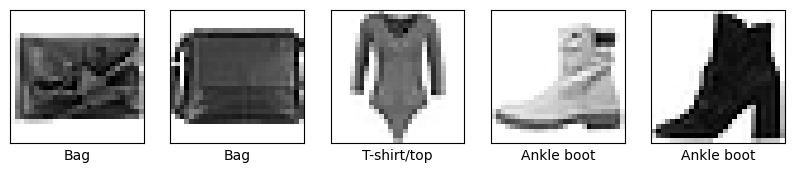

In [4]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Exercise 1: A quick benchmark (Ira Manalo)

Begin with a fast baseline comparison using:
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Linear SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)
- [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Open the documentation pages linked above to familiarize yourself with the main arguments and defaults.

To check whether a model is **memorizing** the training data (overfitting), we will report both training and validation performance. Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) so you can obtain train and test scores in one call (instead of using [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)).

For speed, do not run on the full dataset yet. For the experiments in this section, use only **10%** of the available samples.


In [5]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

Using the reduced 10% subset, we can now fit the three classifiers and estimate their performance.


### Exercise 1.1

Write a function below that takes a list of classifiers and evaluates each one on the provided dataset. The function should return **two lists**:
- the cross-validated **training** scores
- the cross-validated **test/validation** scores

You may import extra utilities if you want, but the task can be completed with the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function plus standard Python tools. An example of the expected output format is shown further down.


In [6]:
from sklearn.model_selection import cross_validate


def evaluate_learners(classifiers, X, y):
   """Evaluate each classifier using cross-validation.

   Returns:
       train_scores: list of arrays (one array per classifier)
       test_scores: list of arrays (one array per classifier)
   """

   train_scores = []
   test_scores = []

   for clf in classifiers:
       scores = cross_validate(
           clf,
           X,
           y,
           cv=5,
           scoring="accuracy",
           return_train_score=True,
           n_jobs=-1
       )

       train_scores.append(scores["train_score"])
       test_scores.append(scores["test_score"])

   return train_scores, test_scores


### Exercise 1.2

Use your function from Exercise 1.1 with the following models:
- Logistic Regression
- Linear SVM
- k-Nearest Neighbors

Save the returned results in `train_scores` and `test_scores`. After that, run the plotting cell provided below to visualize the scores.


In [7]:
classifiers = [
   LogisticRegression(max_iter=1000),
   LinearSVC(max_iter=5000),
   KNeighborsClassifier()
]


train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)


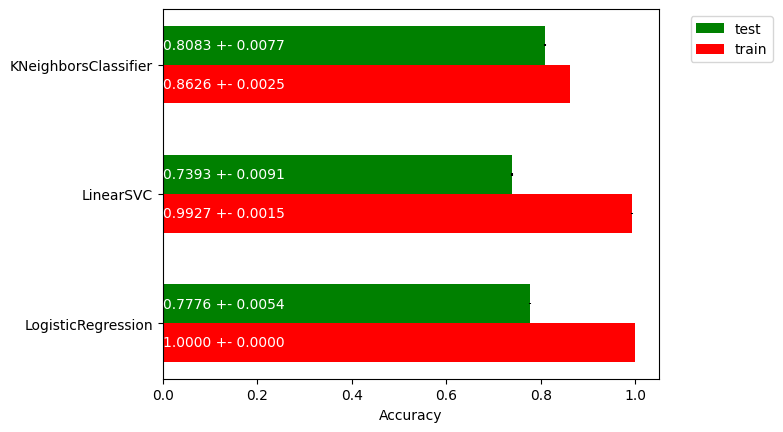

In [8]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3

Explain what you see in the plot:
1.3
- Which model performs best on the validation/test scores? 
    - kNN performs best, with the highest mean of 0.8083 and an std of 0.0077, generalizing better than Linear SVC and Logistic Regression.
- Do any models show signs of overfitting (train score high, test score noticeably lower)? 
    - In the classifiers Linear SVC and Logistic Regression, overfitting is highly noticeable as there is a huge gap between the scores. The train scores are also significantly greater than their test scores, showing memorization.
- If overfitting appears, what practical steps could reduce it? 
    - To reduce overfitting, regularization should be used to control model complexity by penalizing large model coefficients and encouraging simpler models that generalize better to unseen data.
- Do the scores look stable across folds, or is there noticeable variability? 
    - Given that the stds across folds are less than 0.02, with values of 0.0077, 0.0091, and 0.0054, the scores are very stable.




## Exercise 2: Regularization (Jeydin Tacata)

Next, explore how the main complexity/regularization settings affect performance:

- For SVMs, tune the misclassification cost \(C\).
- For logistic regression, tune the regularization strength parameter \(C\).
- For kNN, tune the number of neighbors `n_neighbors`.

Use these search ranges:
- $C \in [10^{-12}, 10^{12}]$ (scan on a **log scale**, e.g., 0.01, 0.1, 1, 10, 100, …)
- `n_neighbors` from 1 to 50 (scan on a **uniform** scale, e.g., 1, 2, 3, 4, …)


### Exercise 2.1

Sweep the hyperparameter ranges above and, for each classifier, create a **line plot** showing:
- mean training score (5-fold CV)
- mean test/validation score (5-fold CV)

You should end up with **three** plots (one per classifier). Only plot the **means** across folds.

Hints:
- Keep runtime in mind: too many hyperparameter values can make this slow.
- Useful NumPy helpers: [`logspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [`linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace).
- Use Matplotlib’s basic [`plot`](https://matplotlib.org/tutorials/introductory/pyplot.html) for the curves.
- You can loop manually, or you can try scikit-learn’s [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (we will revisit it later in the course).


#### Work area


In [9]:


# Generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied


def plot_tuning(grid_search, param_name, ax, log_scale=True):

    params = grid_search.cv_results_['param_' + param_name].data
    train_scores = grid_search.cv_results_['mean_train_score']
    test_scores = grid_search.cv_results_['mean_test_score']

    ax.plot(params, test_scores, marker='.', label='Test score')
    ax.plot(params, train_scores, marker='.', label='Train score')

    ax.set_xlabel(param_name)
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title(type(grid_search.best_estimator_).__name__)

    if log_scale:
        ax.set_xscale('log')

    bp = grid_search.best_params_[param_name]
    bs = grid_search.best_score_

    ax.text(bp, bs,
            f"{param_name}:{bp:.2E}\nACC:{bs:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


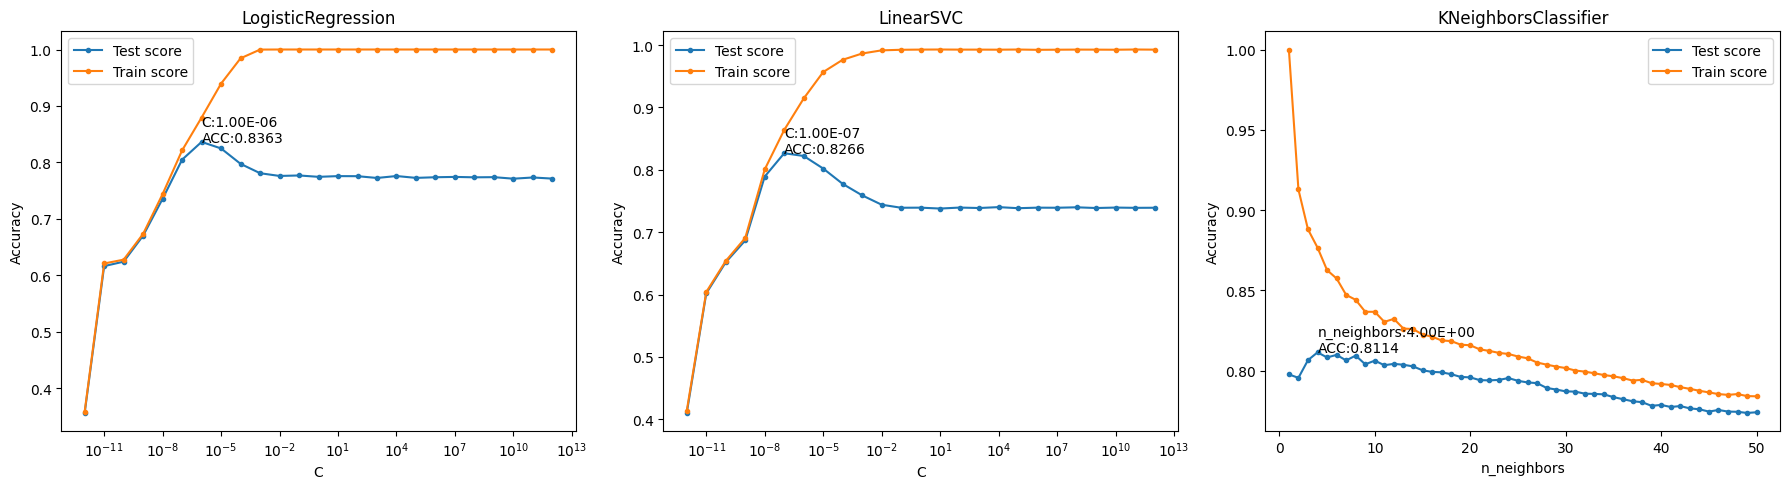

In [13]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-12, 12, 25)
k_range = np.arange(1, 51)

#LogisticRegression

logreg = LogisticRegression(max_iter=1000)

param_grid_log = {'C': C_range}

gs_log = GridSearchCV(
    logreg,
    param_grid_log,
    cv=5,
    n_jobs=4,
    verbose=1,
    return_train_score=True
)

gs_log.fit(Xs, ys)

#LinearSVC
svc = LinearSVC(max_iter=5000, dual=False)

param_grid_svc = {'C': C_range}

gs_svc = GridSearchCV(
    svc,
    param_grid_svc,
    cv=5,
    n_jobs=4,
    verbose=1,
    return_train_score=True
)

gs_svc.fit(Xs, ys)

#kNN
knn = KNeighborsClassifier()

param_grid_knn = {'n_neighbors': k_range}

gs_knn = GridSearchCV(
    knn,
    param_grid_knn,
    cv=5,
    n_jobs=4,
    verbose=1,
    return_train_score=True
)

gs_knn.fit(Xs, ys)


#plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_tuning(gs_log, 'C', axes[0], log_scale=True)
plot_tuning(gs_svc, 'C', axes[1], log_scale=True)
plot_tuning(gs_knn, 'n_neighbors', axes[2], log_scale=False)

plt.tight_layout()
plt.show()


### Exercise 2.2

Discuss the trends in your curves:
- For which settings do you see underfitting (both scores low)?
    - Underfitting (High Bias)Underfitting occurs in the LogisticRegression and LinearSVC models when $C$ is set below $10^{-9}$, where both the training and test scores stay equally low at around 0.40. In this range, the models are too heavily restricted to learn any real patterns, resulting in a "flat" performance that fails to capture the data's structure.

- For which settings do you see overfitting (training higher than test)?
    - Overfitting is mostly seen in the linear models when C exceeds 10^-5, as the training score hits a perfect 1.0 while the test score drops and stays around 0.77. For the KNeighborsClassifier, the strongest overfitting happens at low values n_neighbors, where the model perfectly memorizes every training point but performs poorly on new test data.

- How strongly does each method react to changes in its hyperparameter?
    - The LogisticRegression and LinearSVC models are extremely sensitive, showing a sharp peak where accuracy shoots up and then quickly overrfits when C changes going higher. On the other hand, the KNeighborsClassifier is much more stable and reacts gradually, with its accuracy slowly drifting downward as the number of neighbors increases past the optimal point of 4.


## Exercise 3: Interpreting misclassifications (Mark Lawrence Balading)

Even with tuning, the classifiers will still make mistakes. In this section you will inspect **what kinds of errors** the model makes and which classes tend to be confused.

Train a logistic regression model with `C=1e-7`. Use a training set and a test set sampled from your 10% subset, then generate predictions for the test set.


In [14]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

### Exercise 3.1

Following the setup above:
1. Train the classifier.
2. Compute predictions on the test set and store them in `y_pred`.
3. Identify the indices/samples that were predicted incorrectly and store them in `misclassified_samples`.

Then run the visualization cell below to inspect the misclassified examples.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Use a pipeline (important for pixel features)
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=1e-7, max_iter=1000)
)


clf.fit(X_train, y_train)


# Implement the code to obtain the actual predictions on the test set
y_pred = clf.predict(X_test)


# Implement the code to obtain the indices of the misclassified samples
# Example output:
# misclassified_samples = [  11,   12,   14,   23,   30,   34,   39,   46,   50,   52,   55]


misclassified_samples = np.where(y_pred != y_test.values)[0]


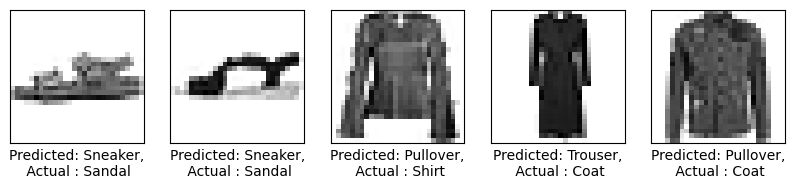

In [16]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test.values[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (fmnist_classes[int(y_pred[i])],fmnist_classes[int(y_test.values[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

### Exercise 3.2

Comment on what you observe. Do the incorrect predictions make sense given the images? Briefly explain why some classes might be hard to separate with a linear model.


**Answer:**

Let’s run through the misinterpretations: sandals as sneakers, shirt as a pullover, coat as trousers, coat as a pullover. These misinterpretations make sense. Considering that we used linear models, it might have been detected, say, that the sandal was a sneaker because it had the same shape, and that was enough for the model, as that is what linear models do in image recognition through vectors and heatmaps. When we look at the other misinterpretations, pullover being a shirt and a coat makes sense because they both cover the upper body and have sleeves until the wrist. They may just vary with the number of buttons or the type of collar and material. Coat being a trouser may have been interpreted like that because it has the same long shape, only this time the “trouser” has some funny pockets, but still follows that narrowing shape with the shoulders being the wide end just like a waist band and the hem of the coat being the hem of the trouser.



### Exercise 3.3

Run the provided code cell to plot the full confusion matrix.

A confusion matrix counts how many samples fall into each (true label, predicted label) pair. Use it to answer:
- Which pairs of classes are most often confused?
    - The pairs most confused are: coat and pullover, t-shirt and dress, dress and coat, and sandal and ankle boot. As discussed before, the coat and pullover confusion makes sense as their shape is quite similar. While the model may make some improvements in understanding what a dress is, or maybe it was difficult for the model to comprehend the different types of dresses.

- Do you see any systematic error patterns (some types of mistakes happening much more frequently than others)?
    - Based on the collected data, upper-body clothing is commonly mistaken for one another. Since they have the same shape, the model is confused about which one is which. And, this is also true with the sandal-sneaker combo. They both have the same flat base and a curve for the foot that resembles each other. Additionally, it is quite alarming that many of the items are misidentified as sandals. Its column is distinctly bright.

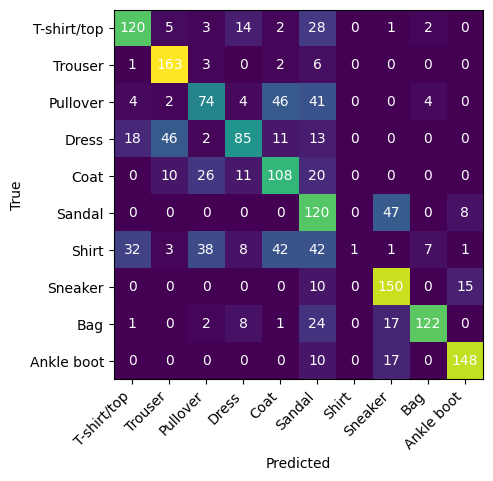

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

## Exercise 4: Interpreting model parameters (Carlos Quicho)

Finally, examine what the linear models have learned by looking at their coefficients.

Because each image has 28×28 pixels, the input has 784 features, so each linear classifier learns 784 weights (per class). We will reshape these weights back into 28×28 images to see which pixels the model treats as informative.


### Exercise 4.1

Train:
- a Logistic Regression model
- a Linear SVM model

Use the hyperparameters you found in Exercise 2. If you are unsure, use `C=1e-7` for logistic regression and `C=1e-8` for the SVM.

Pass each trained model to the provided plotting function and interpret the resulting weight-visualizations in detail:
- Why do you get multiple coefficient images per model?
    - Since there are 10 clothing classes, the model learns a separate set of weights for each class, giving us 10 heatmaps per model.

- In this dataset, what does a “feature” correspond to?
    - Each feature is a single pixel in the 28x28 image, so 784 features total.

- Do the learned weights emphasize sensible parts of the images?
    - Mostly yes. For example, Trouser shows high weights along the leg area, and Bag shows a compact centered region. The shapes roughly match what you would expect each item to look like.

- Do you notice pixels/features that appear largely ignored?
    - Yes, the corners and outer edges are mostly near zero since the clothing items are centered and rarely reach those areas.

- Are some classes easier/harder to capture than others?
    - Trouser and Bag seem easier since they have distinct shapes. Classes like Shirt, Pullover, and Coat are harder because they look very similar to each other, making it harder for a linear model to separate them cleanly.

- Do you see notable differences between logistic regression and the SVM?
    - The Logistic Regression looks sharper and have a bit more detail, which helps it pick up on specific pixel patterns to get a slightly higher accuracy. On the other hand, the SVM images are smoother and focus more on the general shape of the clothes, making it a bit more stable but with less precision.


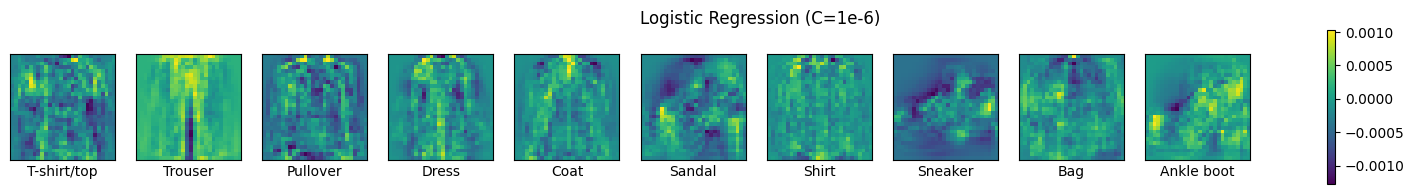

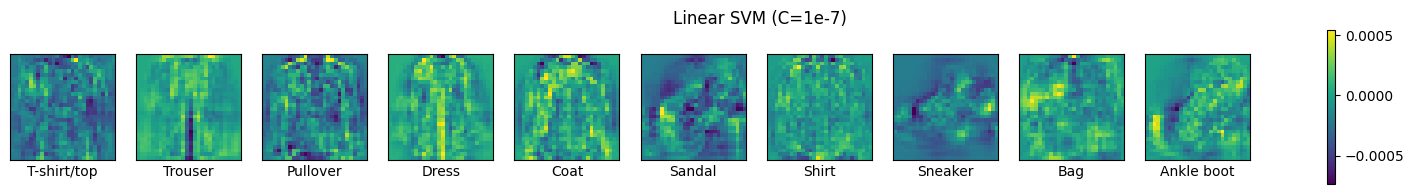

In [20]:
# Plots the coefficients of the given model as 28x28 heatmaps.
# The `name` attribute is optional, it is simply a title for the produced figure
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())


# Train Logistic Regression with best C
log_reg = LogisticRegression(C=1e-6, max_iter=1000)
log_reg.fit(X_train, y_train)

# Train Linear SVM with best C
svm = LinearSVC(C=1e-7, max_iter=5000)
svm.fit(X_train, y_train)

# Plot coefficients for both models
plot_coefficients(log_reg, name="Logistic Regression (C=1e-6)")
plot_coefficients(svm, name="Linear SVM (C=1e-7)")


### Exercise 4.2

Repeat Exercise 4.1, but only for logistic regression.

This time, include three versions:
1. a tuned model (your best setting)
2. an intentionally **overfitting** setting
3. an intentionally **underfitting** setting

Compare the coefficient visualizations and explain how the degree of regularization changes what the model focuses on.

**Answer:**

In the underfit setting where regularization is extremely strong, the coefficients look like smooth, blurry silhouettes that represent the average shape of each clothing item. The model only focuses on the most basic global outlines, like the general rectangular shape of a "T-shirt" or the long vertical bars of "Trousers," because the high penalty prevents it from learning any specific details.

In the overfit setting where there is almost no regularization, the visualizations become very "noisy" and filled with sharp, scattered pixels. Instead of focusing on the actual shape of the clothes, the model is reacting to random pixel variations and noise in the training set that don't actually relate to the clothing category.

The tuned model shows a balanced middle ground where the coefficients highlight distinct, recognizable features like sleeves, collars, and edges. By using an optimal regularization strength, the model focuses on the most important structural parts of the garment that help it distinguish a "Coat" from a "Shirt" without getting distracted by random noise.

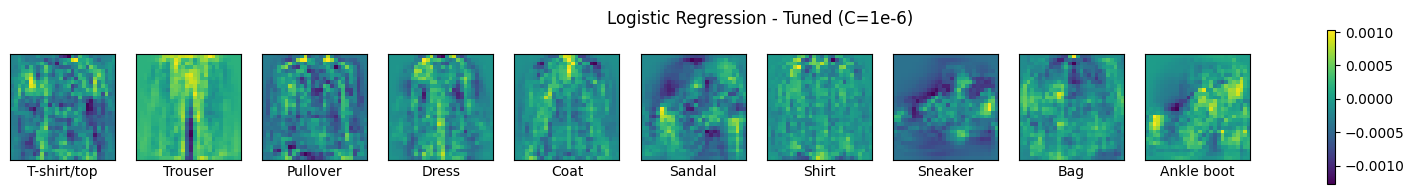

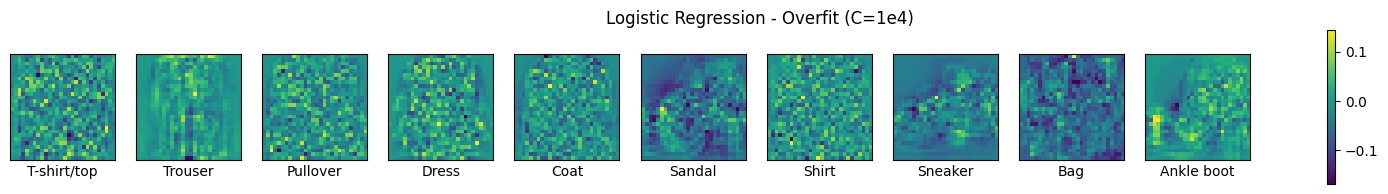

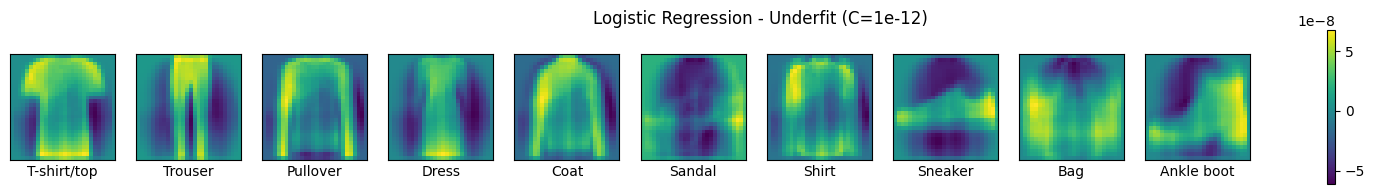

In [21]:
# 1. Tuned model (best C from Exercise 2)
log_reg_tuned = LogisticRegression(C=1e-6, max_iter=1000)
log_reg_tuned.fit(X_train, y_train)

# 2. Overfitting model (very high C = less regularization)
log_reg_overfit = LogisticRegression(C=1e4, max_iter=1000)
log_reg_overfit.fit(X_train, y_train)

# 3. Underfitting model (very low C = more regularization)
log_reg_underfit = LogisticRegression(C=1e-12, max_iter=1000)
log_reg_underfit.fit(X_train, y_train)

# Plot all three
plot_coefficients(log_reg_tuned, name="Logistic Regression - Tuned (C=1e-6)")
plot_coefficients(log_reg_overfit, name="Logistic Regression - Overfit (C=1e4)")
plot_coefficients(log_reg_underfit, name="Logistic Regression - Underfit (C=1e-12)")
